# SED training data for NPE 
The SED trianing data is generated from
1. $\theta_{\rm SPS}'\sim p(\theta_{\rm SPS})$ --- sample SPS parameters from prior
2. $f_\lambda' = S(\theta_{\rm SPS}$ where $S$ is the SED model --- generate SED for sampled parameters
3. $m = F(f_\lambda')$ --- generate magnitude $m$ by forward modeling with $F$ the SED

In this notebook, I will compile them and apply a realistic noise model

In [1]:
import os, sys
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('.'))))
import sedflow as SEDflow
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## load pre-computed SEDs
These were compiled in `compile_sed_data.ipynb`

In [2]:
dat_dir = '/scratch/network/chhahn/arcoiris/sedflow/'

In [3]:
# load training data
train_xs_flux = np.load(os.path.join(dat_dir, 'data.flux_nonoise.npy'))
train_xs_mags = np.load(os.path.join(dat_dir, 'data.mags_nonoise.npy'))
train_zreds = np.load(os.path.join(dat_dir, 'data.zreds.npy'))
train_props = np.load(os.path.join(dat_dir, 'data.props.npy'))
train_thetas_unt = np.load(os.path.join(dat_dir, 'data.thetas_unt.npy'))
train_thetas_sps = np.load(os.path.join(dat_dir, 'data.thetas_sps.npy'))

# load test data
test_xs_flux = np.load(os.path.join(dat_dir, 'test.flux_nonoise.npy'))
test_xs_mags = np.load(os.path.join(dat_dir, 'test.mags_nonoise.npy'))
test_zreds = np.load(os.path.join(dat_dir, 'test.zreds.npy'))
test_props = np.load(os.path.join(dat_dir, 'test.props.npy'))
test_thetas_unt = np.load(os.path.join(dat_dir, 'test.thetas_unt.npy'))
test_thetas_sps = np.load(os.path.join(dat_dir, 'test.thetas_sps.npy'))

## Load NSA data

In [4]:
# load NSA data
nsa, _ = SEDflow.NSA()

flux_nsa = nsa['NMGY'][:,2:]
ivar_nsa = nsa['NMGY_IVAR'][:,2:]

zred_nsa = nsa['Z']

mags_nsa = SEDflow.flux2mag(flux_nsa)
sigs_nsa = SEDflow.sigma_flux2mag(ivar_nsa**-0.5, flux_nsa)

snrs_nsa = flux_nsa * ivar_nsa**0.5

/home/chhahn/projects/arcoiris/bin/sedflow/sedflow.py:209: RuntimeWarning: invalid value encountered in log10
  return 22.5 - 2.5 * np.log10(flux)


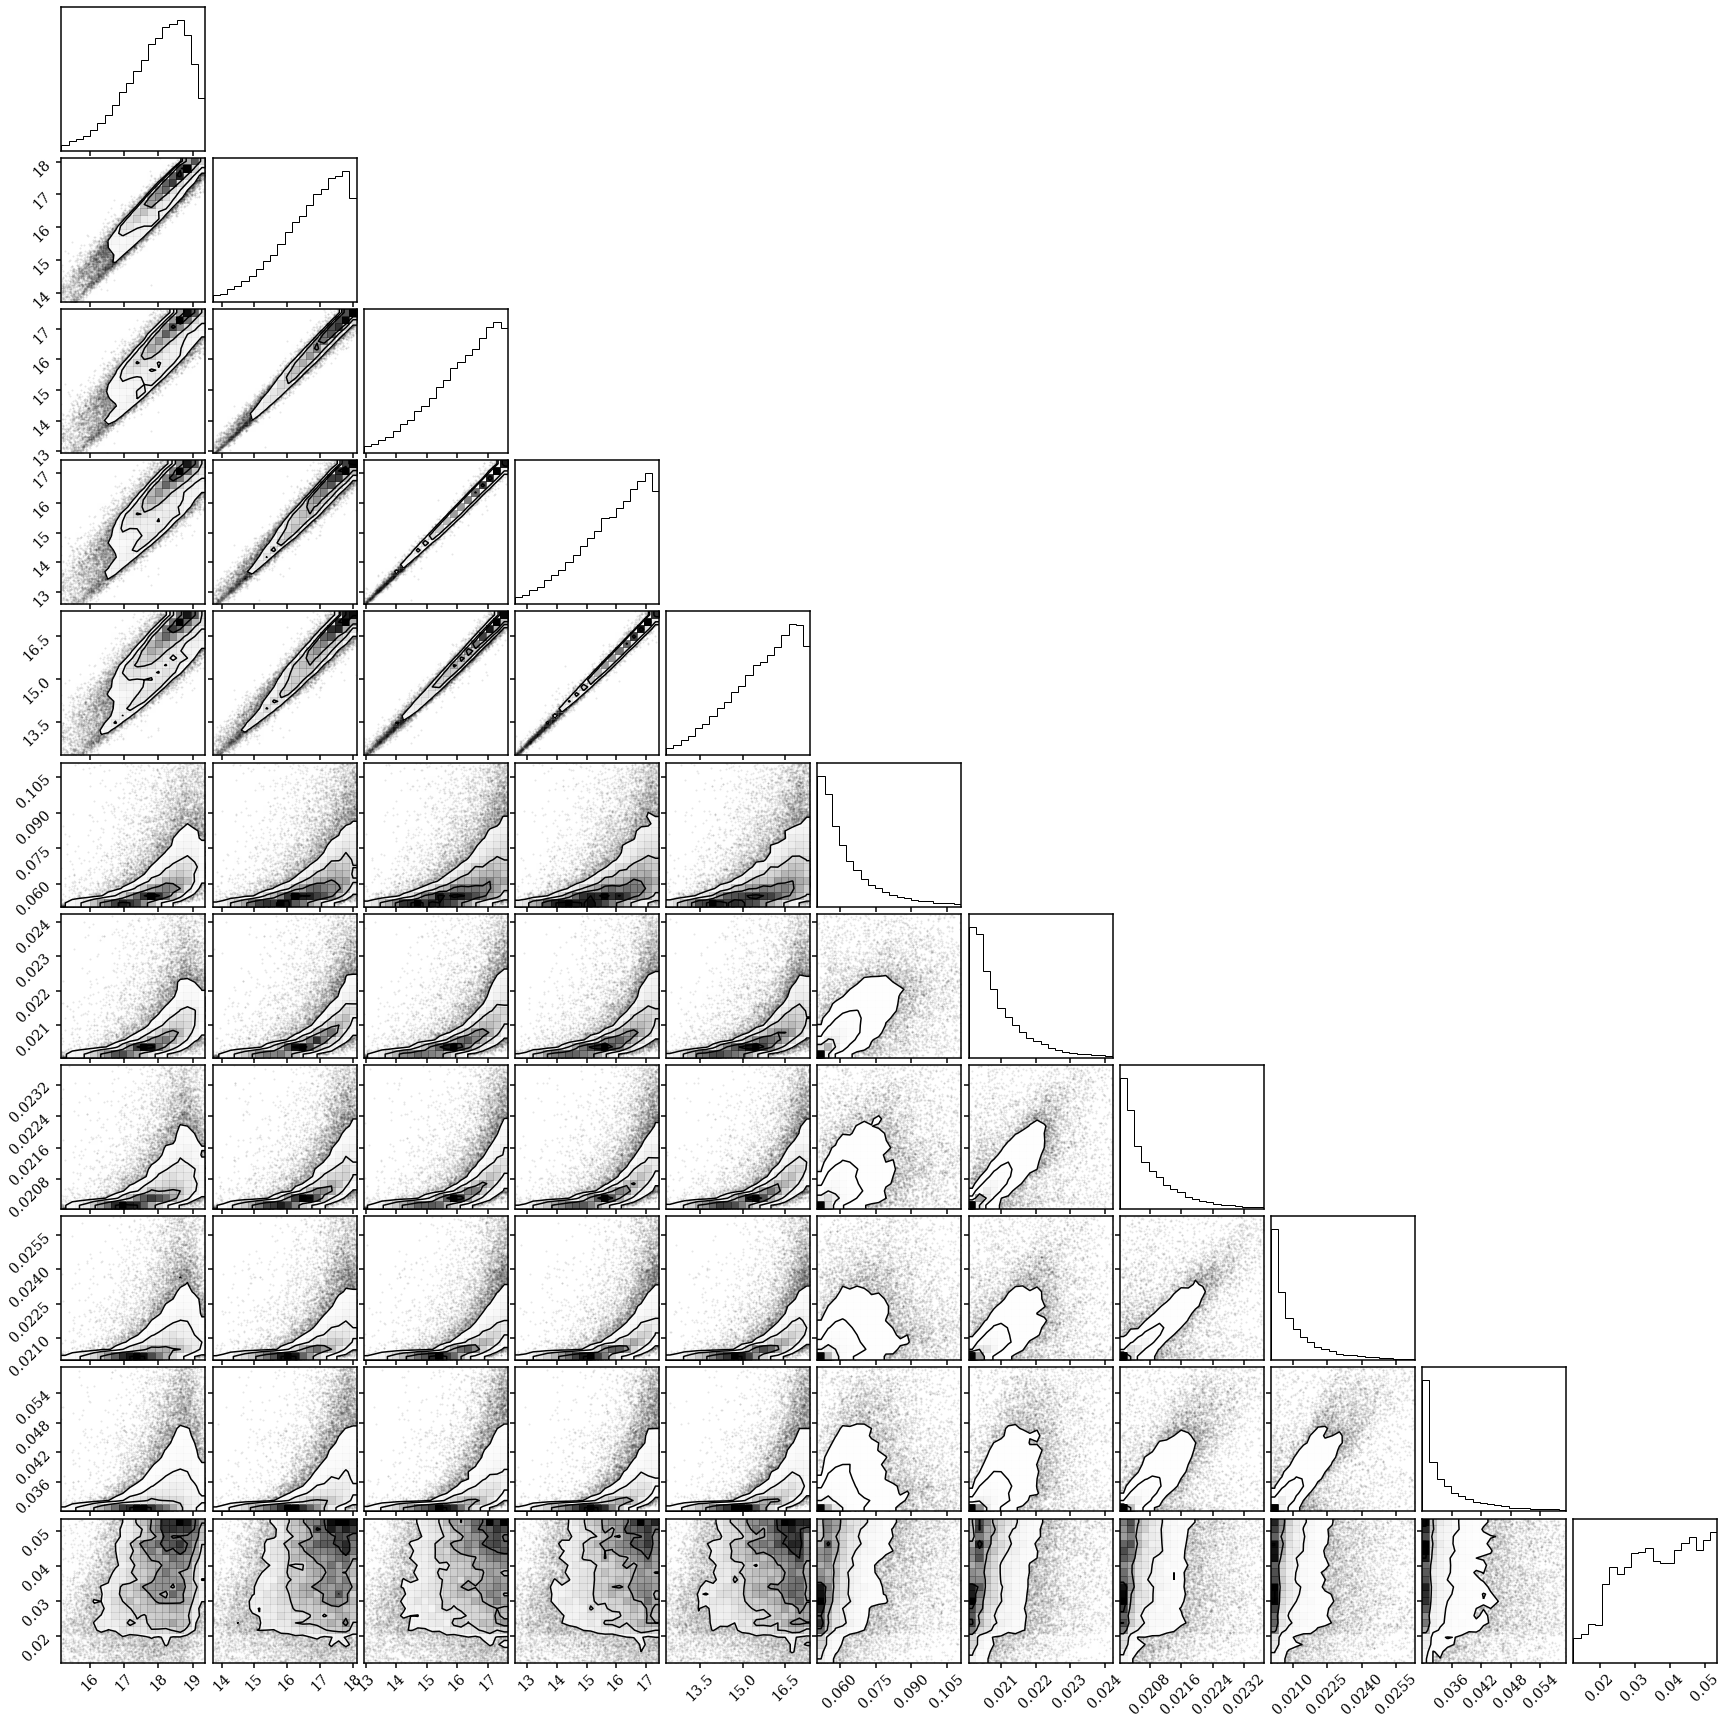

In [5]:
fig = DFM.corner(np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), 
                 range=np.nanquantile(np.concatenate([mags_nsa, sigs_nsa, zred_nsa[:,None]], axis=1), [0.01, 0.95], axis=0).T)

## trim SED data based on magnitude

In [6]:
train_mags_cut = np.ones(train_xs_mags.shape[0]).astype(bool)
test_mags_cut = np.ones(test_xs_mags.shape[0]).astype(bool)

for i in range(5):
    train_mags_cut &= (train_xs_mags[:,i] > np.nanmin(mags_nsa[:,i])) & (train_xs_mags[:,i] < np.nanmax(mags_nsa[:,i]))
    test_mags_cut &= (test_xs_mags[:,i] > np.nanmin(mags_nsa[:,i])) & (test_xs_mags[:,i] < np.nanmax(mags_nsa[:,i]))

print(np.mean(train_mags_cut), np.mean(test_mags_cut))

0.565791 0.56665


In [7]:
# load training data
train_xs_flux = train_xs_flux[train_mags_cut]
train_xs_mags = train_xs_mags[train_mags_cut]
train_zreds = train_zreds[train_mags_cut]
train_props = train_props[train_mags_cut]
train_thetas_unt = train_thetas_unt[train_mags_cut]
train_thetas_sps = train_thetas_sps[train_mags_cut]

# load test data
test_xs_flux = test_xs_flux[test_mags_cut]
test_xs_mags = test_xs_mags[test_mags_cut]
test_zreds = test_zreds[test_mags_cut]
test_props = test_props[test_mags_cut]
test_thetas_unt = test_thetas_unt[test_mags_cut]
test_thetas_sps = test_thetas_sps[test_mags_cut]

## fit noise model $\sigma_X({\rm mag}_X)$ to NSA catalog

In [8]:
def trimmed_median(x): 
    xlim = np.quantile(x, [0.0, 0.95])
    return np.median(x[(x > xlim[0]) & (x < xlim[1])])

def trimmed_std(x): 
    xlim = np.quantile(x, [0.0, 0.95])
    return np.std(x[(x > xlim[0]) & (x < xlim[1])])

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


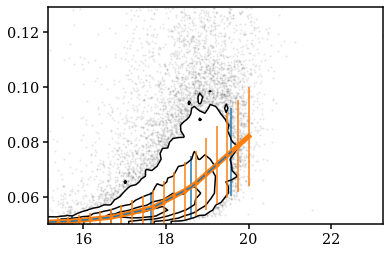

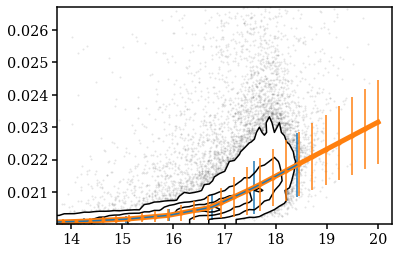

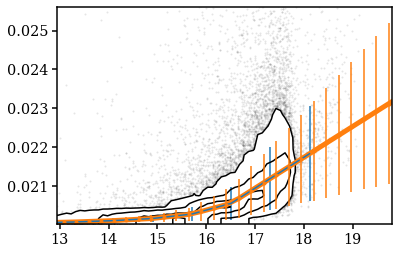

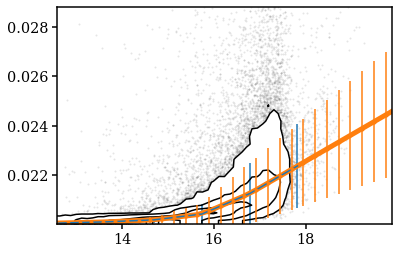

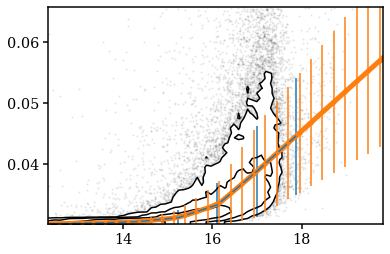

In [9]:
meds_sigs, stds_sigs = [], [] 

for i in range(5): 
    clean = (np.isfinite(mags_nsa[:,i]) & (sigs_nsa[:,i] < np.max([np.quantile(sigs_nsa[:,i], 0.99), 0.05])))

    med_sig, mags_edges, _ = binned_statistic(mags_nsa[clean,i], sigs_nsa[clean,i], statistic=trimmed_median, range=np.nanquantile(mags_nsa[clean,i], [0., 0.995]), bins=10)
    std_sig, mags_edges, _ = binned_statistic(mags_nsa[clean,i], sigs_nsa[clean,i], statistic=trimmed_std, range=np.nanquantile(mags_nsa[clean,i], [0., 0.995]), bins=10)
    
    finite = (np.isfinite(med_sig) & np.isfinite(std_sig))
    meds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], med_sig[finite], fill_value='extrapolate'))
    stds_sigs.append(interp1d(0.5*(mags_edges[1:] + mags_edges[:-1])[finite], std_sig[finite], fill_value='extrapolate'))
    
    fig = plt.figure(figsize=(6,4))
    sub = fig.add_subplot(111)
    sub.plot(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig, c='C0')
    sub.errorbar(0.5*(mags_edges[1:] + mags_edges[:-1]), med_sig,
                 yerr=std_sig, c='C0')
    DFM.hist2d(mags_nsa[clean,i], sigs_nsa[clean,i], plot_density=False, bins=100, ax=sub)
    
    sub.plot(np.linspace(10, 20, 40), meds_sigs[-1](np.linspace(10, 20, 40)), c='C1', lw=5)
    sub.errorbar(np.linspace(10, 20, 40), meds_sigs[-1](np.linspace(10, 20, 40)), 
                 yerr=stds_sigs[-1](np.linspace(10, 20, 40)), fmt='.C1')
    sub.set_xlim(np.nanquantile(mags_nsa[clean,i], [0.01, 1.]))
    sub.set_ylim(np.nanquantile(sigs_nsa[clean,i], [0.0, 0.975]))


In [10]:
def apply_toy_noise(flux, mags, zreds, props, thetas_unt, thetas_sps): 
    ''' apply toy noise model
    '''
    sigs_noisy, sigs_flux_noisy = [], [] 
    flux_noisy, mags_noisy = [], []
    for i in range(5):
        _sig_mags = meds_sigs[i](mags[:,i]) + stds_sigs[i](mags[:,i]) * np.random.normal(size=mags.shape[0])
        _sig_flux = SEDflow.sigma_mag2flux(_sig_mags, mags[:,i])
        
        _flux_noisy = flux[:,i] + _sig_flux * np.random.normal(size=mags.shape[0])
        _mags_noisy = SEDflow.flux2mag(_flux_noisy)
    
        sigs_noisy.append(_sig_mags)
        sigs_flux_noisy.append(_sig_flux)
        
        flux_noisy.append(_flux_noisy)
        mags_noisy.append(_mags_noisy)
    
    sigs_noisy = np.array(sigs_noisy).T
    sigs_flux_noisy = np.array(sigs_flux_noisy).T
    flux_noisy = np.array(flux_noisy).T
    mags_noisy = np.array(mags_noisy).T
    
    positive_noise = np.all((sigs_noisy > 0.), axis=1)
    mags_noisy = mags_noisy[positive_noise,:]
    flux_noisy = flux_noisy[positive_noise,:]
    sigs_noisy = sigs_noisy[positive_noise,:]
    sigs_flux_noisy = sigs_flux_noisy[positive_noise,:]
    zreds = zreds[positive_noise,:]
    props = props[positive_noise,:]
    thetas_unt = thetas_unt[positive_noise,:]
    thetas_sps = thetas_sps[positive_noise,:]
    
    assert np.sum(~np.isfinite(mags_noisy)) == 0
    assert np.sum(~np.isfinite(sigs_noisy)) == 0
    
    return mags_noisy, flux_noisy, sigs_noisy, sigs_flux_noisy, zreds, props, thetas_unt, thetas_sps

In [11]:
train_toynoise = apply_toy_noise(
    train_xs_flux, train_xs_mags, train_zreds, train_props, train_thetas_unt, train_thetas_sps
)

test_toynoise = apply_toy_noise(
    test_xs_flux, test_xs_mags, test_zreds, test_props, test_thetas_unt, test_thetas_sps
)

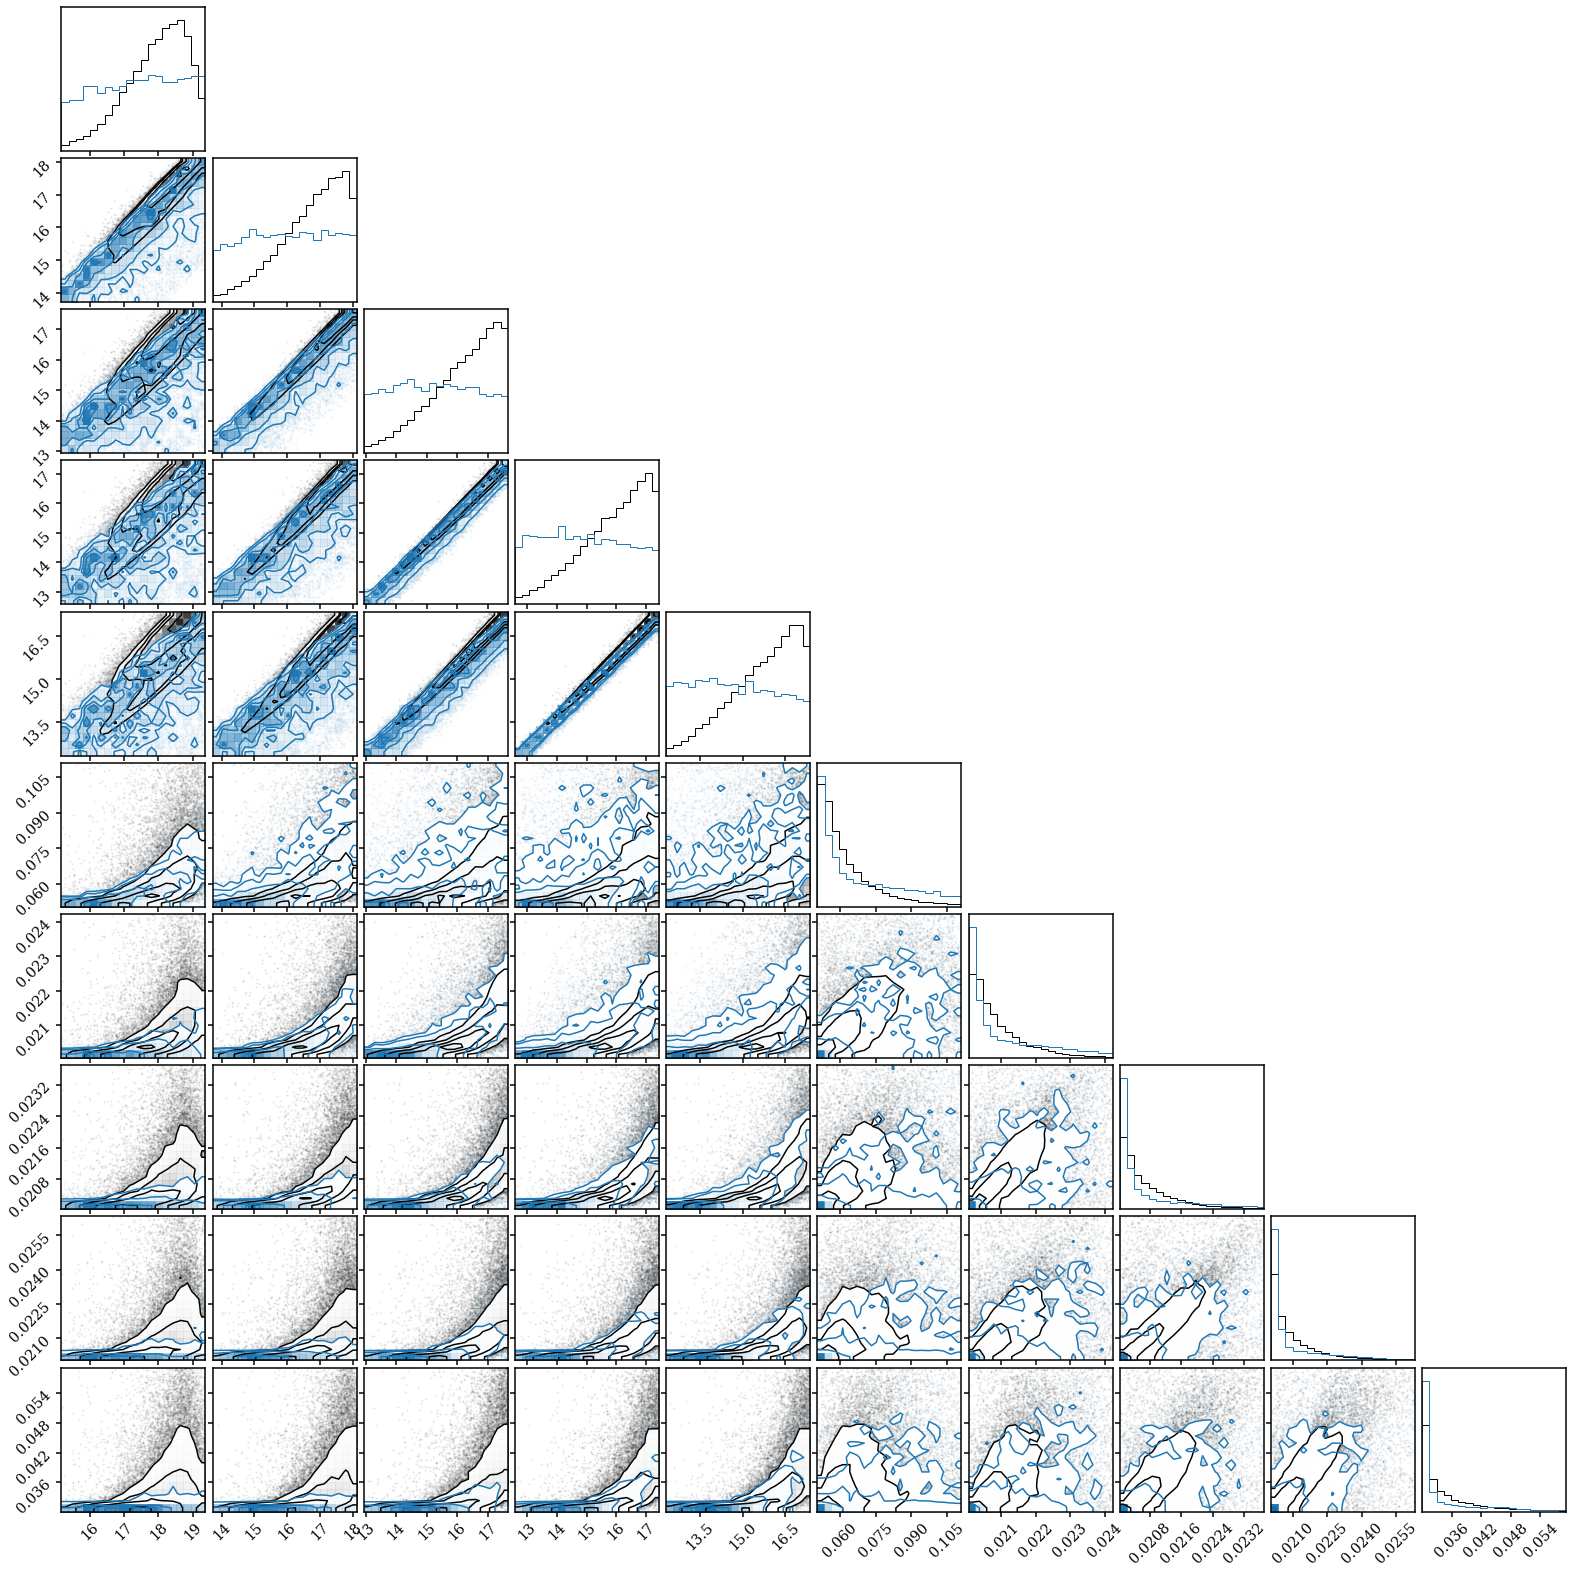

In [12]:
fig = DFM.corner(np.concatenate([mags_nsa, sigs_nsa], axis=1), 
                 range=np.nanquantile(np.concatenate([mags_nsa, sigs_nsa], axis=1), [0.01, 0.95], axis=0).T, 
                 color='k', hist_kwargs={'density': True})
_ = DFM.corner(np.concatenate([train_toynoise[0], train_toynoise[2]], axis=1)[::100],
               range=np.nanquantile(np.concatenate([mags_nsa, sigs_nsa], axis=1), [0.01, 0.95], axis=0).T, 
               color='C0', hist_kwargs={'density': True}, fig=fig)

In [13]:
np.save(os.path.join(dat_dir, 'data.v1.mags.toy_noise.npy'), train_toynoise[0])
np.save(os.path.join(dat_dir, 'data.v1.flux.toy_noise.npy'), train_toynoise[1])
np.save(os.path.join(dat_dir, 'data.v1.sigs.toy_noise.npy'), train_toynoise[2])
np.save(os.path.join(dat_dir, 'data.v1.sigs_flux.toy_noise.npy'), train_toynoise[3])

np.save(os.path.join(dat_dir, 'data.v1.zred.toy_noise.npy'), train_toynoise[4])
np.save(os.path.join(dat_dir, 'data.v1.prop.toy_noise.npy'), train_toynoise[5])
np.save(os.path.join(dat_dir, 'data.v1.thetas_unt.toy_noise.npy'), train_toynoise[6])
np.save(os.path.join(dat_dir, 'data.v1.thetas_sps.toy_noise.npy'), train_toynoise[7])

In [14]:
np.save(os.path.join(dat_dir, 'test.v1.mags.toy_noise.npy'), test_toynoise[0])
np.save(os.path.join(dat_dir, 'test.v1.flux.toy_noise.npy'), test_toynoise[1])
np.save(os.path.join(dat_dir, 'test.v1.sigs.toy_noise.npy'), test_toynoise[2])
np.save(os.path.join(dat_dir, 'test.v1.sigs_flux.toy_noise.npy'), test_toynoise[3])

np.save(os.path.join(dat_dir, 'test.v1.zred.toy_noise.npy'), test_toynoise[4])
np.save(os.path.join(dat_dir, 'test.v1.prop.toy_noise.npy'), test_toynoise[5])
np.save(os.path.join(dat_dir, 'test.v1.thetas_unt.toy_noise.npy'), test_toynoise[6])
np.save(os.path.join(dat_dir, 'test.v1.thetas_sps.toy_noise.npy'), test_toynoise[7])

# deploy NF($\sigma$ | ${\rm mag}, z$) 
NF is trained in `nsa_noise_flow.ipynb`

In [8]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as Ut
from sbi import inference as Inference

load normalizing flow

In [9]:
x_train = sigs_nsa
y_train = np.concatenate([mags_nsa, zred_nsa[:,None]], axis=1)

lower_bounds = torch.tensor([0., 0., 0., 0., 0.])
upper_bounds = torch.tensor(np.max(x_train, axis=0))

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds)

In [10]:
# load normalizing flow
fflow = '/scratch/network/chhahn/arcoiris/nsa_noise_flow.pt'
anpe = Inference.SNPE(prior=prior, density_estimator=Ut.posterior_nn('maf', hidden_features=100), device='cpu')

p_x_y_estimator = anpe._build_neural_net(torch.as_tensor(x_train.astype(np.float32)), torch.as_tensor(y_train.astype(np.float32)))
p_x_y_estimator.load_state_dict(torch.load(fflow, map_location=torch.device('cpu')))

anpe._x_shape = Ut.x_shape_from_simulation(torch.as_tensor(y_train.astype(np.float32)))

In [11]:
hatp_x_y = anpe.build_posterior(p_x_y_estimator)

In [12]:
train_y = np.concatenate([train_xs_mags, train_zreds], axis=1)
test_y = np.concatenate([test_xs_mags, test_zreds], axis=1)

sample $\sigma' \sim {\rm NF} (\sigma | {\rm mag}, z)$

In [13]:
train_sigs_flow = [] 
for i in range(train_y.shape[0]): 
    train_sigs_flow.append(np.array(hatp_x_y.sample((1,), x=torch.as_tensor(train_y[i]), show_progress_bars=False).to('cpu'))[0])
train_sigs_flow = np.array(train_sigs_flow)

In [14]:
train_sigs_flux_flow, train_flux_flow, train_mags_flow = [], [], []
for i in range(5): 
    _sigs_flux = SEDflow.sigma_mag2flux(train_sigs_flow[:,i], train_xs_mags[:,i])
    _flux_noisy = train_xs_flux[:,i] + _sigs_flux * np.random.normal(size=train_xs_flux.shape[0])
    _mags_noisy = SEDflow.flux2mag(_flux_noisy)
    
    train_sigs_flux_flow.append(_sigs_flux)
    train_flux_flow.append(_flux_noisy)
    train_mags_flow.append(_mags_noisy)
    
train_sigs_flux_flow = np.array(train_sigs_flux_flow).T
train_flux_flow = np.array(train_flux_flow).T
train_mags_flow = np.array(train_mags_flow).T

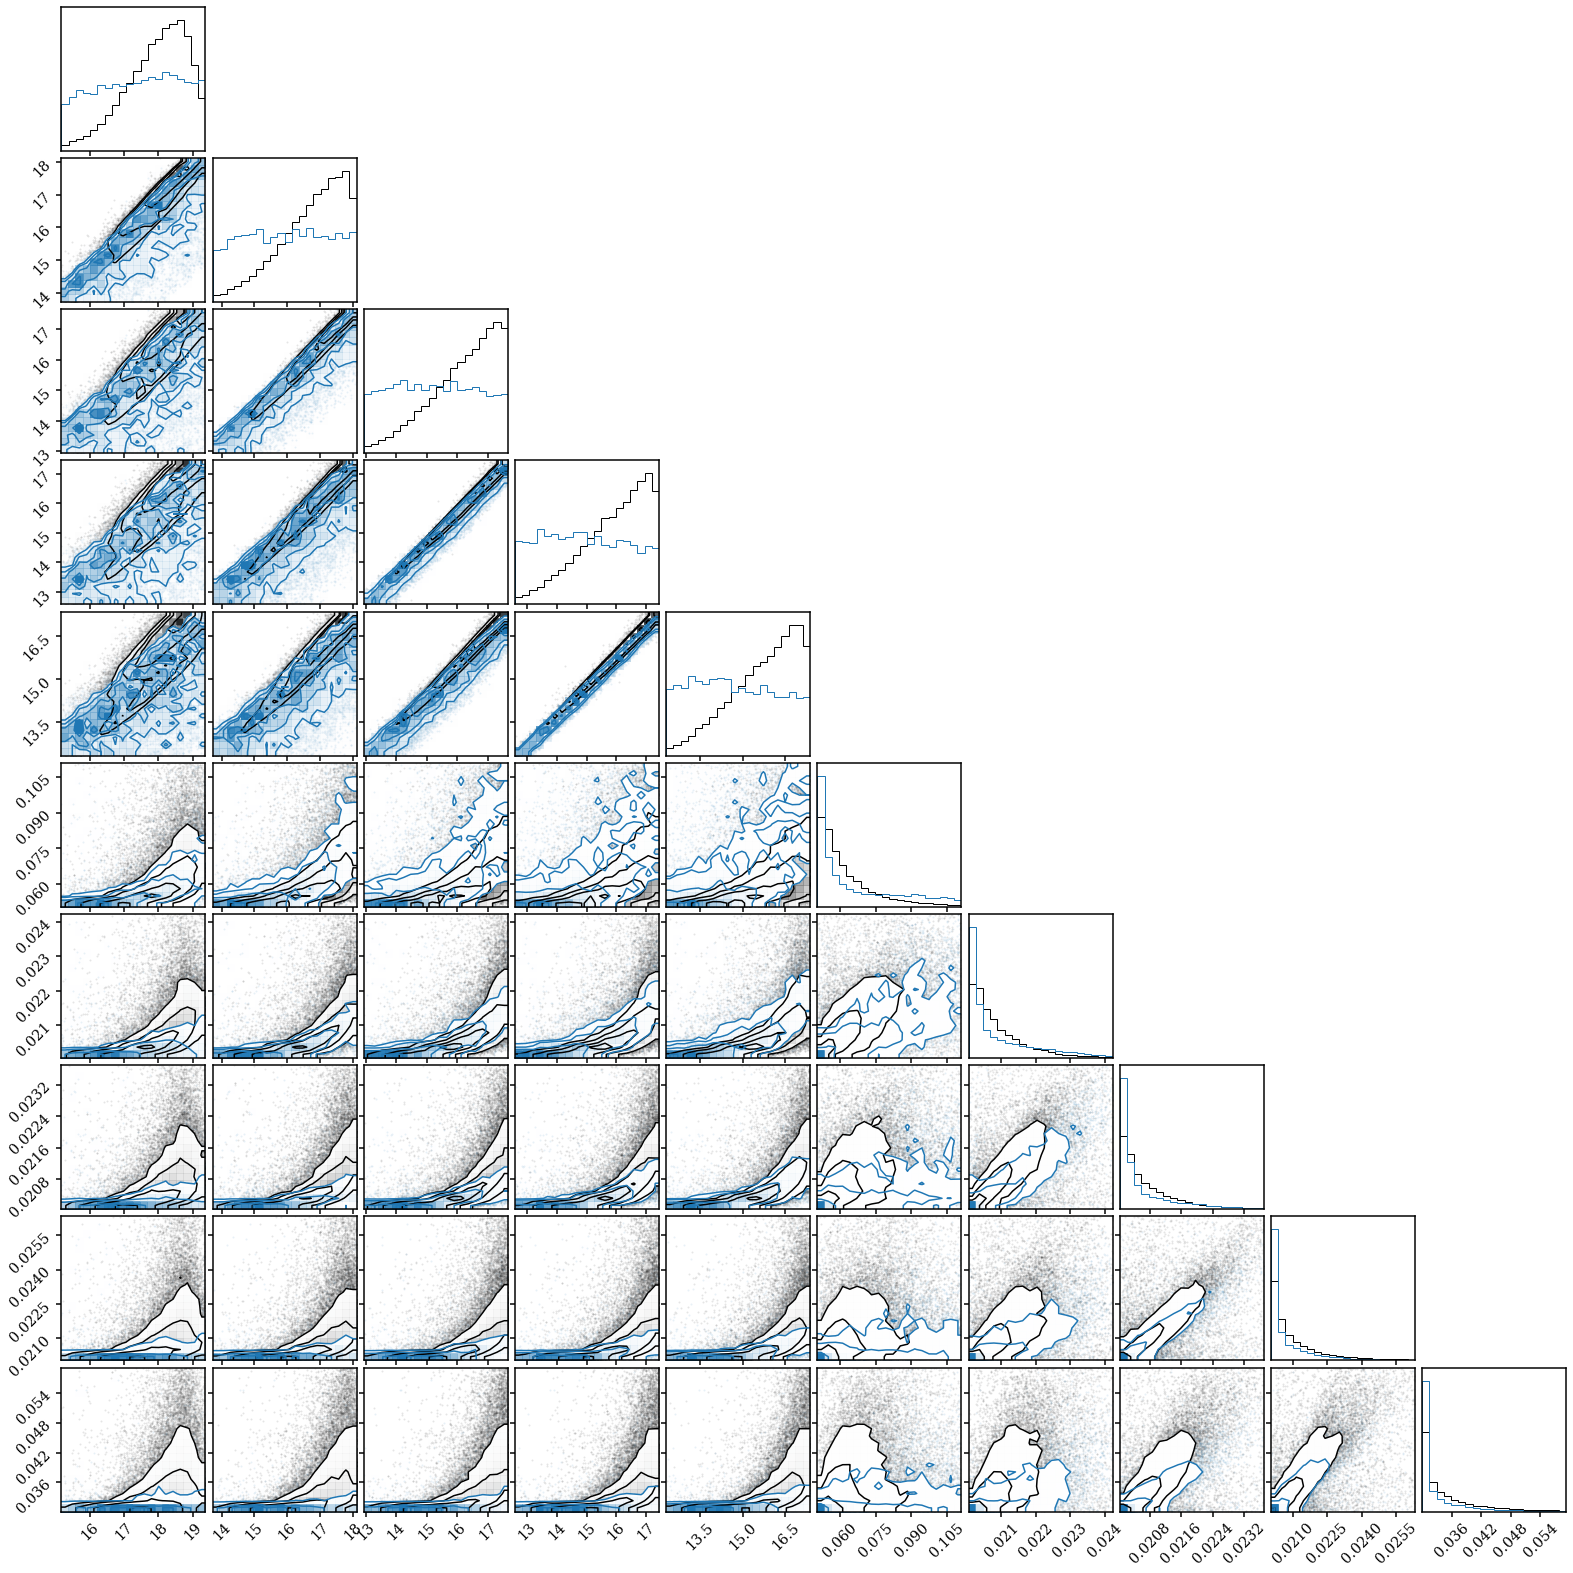

In [15]:
fig = DFM.corner(np.concatenate([mags_nsa, sigs_nsa], axis=1), 
                 range=np.nanquantile(np.concatenate([mags_nsa, sigs_nsa], axis=1), [0.01, 0.95], axis=0).T, 
                 color='k', hist_kwargs={'density': True})
_ = DFM.corner(np.concatenate([train_mags_flow, train_sigs_flow], axis=1)[::100],
               range=np.nanquantile(np.concatenate([mags_nsa, sigs_nsa], axis=1), [0.01, 0.95], axis=0).T, 
               color='C0', hist_kwargs={'density': True}, fig=fig)

In [16]:
test_sigs_flow = [] 
for i in range(test_y.shape[0]): 
    test_sigs_flow.append(np.array(hatp_x_y.sample((1,), x=torch.as_tensor(test_y[i]), show_progress_bars=False).to('cpu'))[0])
test_sigs_flow = np.array(test_sigs_flow)

In [17]:
test_sigs_flux_flow, test_flux_flow, test_mags_flow = [], [], []
for i in range(5): 
    _sigs_flux = SEDflow.sigma_mag2flux(test_sigs_flow[:,i], test_xs_mags[:,i])
    _flux_noisy = test_xs_flux[:,i] + _sigs_flux * np.random.normal(size=test_xs_flux.shape[0])
    _mags_noisy = SEDflow.flux2mag(_flux_noisy)
    
    test_sigs_flux_flow.append(_sigs_flux)
    test_flux_flow.append(_flux_noisy)
    test_mags_flow.append(_mags_noisy)
    
test_sigs_flux_flow = np.array(test_sigs_flux_flow).T
test_flux_flow = np.array(test_flux_flow).T
test_mags_flow = np.array(test_mags_flow).T

In [18]:
positive_noise = np.all((train_sigs_flow > 0.), axis=1)
print(np.sum(~positive_noise))
finite = (np.all(np.isfinite(train_sigs_flow), axis=1) & np.all(np.isfinite(train_mags_flow), axis=1))
print(np.sum(~finite))

0
0


In [19]:
positive_noise = np.all((test_sigs_flow > 0.), axis=1)
print(np.sum(~positive_noise))
finite = (np.all(np.isfinite(test_sigs_flow), axis=1) & np.all(np.isfinite(test_mags_flow), axis=1))
print(np.sum(~finite))

0
0


In [21]:
# trim and save data
np.save(os.path.join(dat_dir, 'data.v1.mags.nsa_flow.npy'), train_mags_flow)
np.save(os.path.join(dat_dir, 'data.v1.flux.nsa_flow.npy'), train_flux_flow)
np.save(os.path.join(dat_dir, 'data.v1.sigs.nsa_flow.npy'), train_sigs_flow)
np.save(os.path.join(dat_dir, 'data.v1.sigs_flux.nsa_flow.npy'), train_sigs_flux_flow)

np.save(os.path.join(dat_dir, 'data.v1.zred.nsa_flow.npy'), train_zreds)
np.save(os.path.join(dat_dir, 'data.v1.prop.nsa_flow.npy'), train_props)
np.save(os.path.join(dat_dir, 'data.v1.thetas_unt.nsa_flow.npy'), train_thetas_unt)
np.save(os.path.join(dat_dir, 'data.v1.thetas_sps.nsa_flow.npy'), train_thetas_sps)

In [22]:
np.save(os.path.join(dat_dir, 'test.v1.mags.nsa_flow.npy'), test_mags_flow)
np.save(os.path.join(dat_dir, 'test.v1.flux.nsa_flow.npy'), test_flux_flow)
np.save(os.path.join(dat_dir, 'test.v1.sigs.nsa_flow.npy'), test_sigs_flow)
np.save(os.path.join(dat_dir, 'test.v1.sigs_flux.nsa_flow.npy'), test_sigs_flux_flow)

np.save(os.path.join(dat_dir, 'test.v1.zred.nsa_flow.npy'), test_zreds)
np.save(os.path.join(dat_dir, 'test.v1.prop.nsa_flow.npy'), test_props)
np.save(os.path.join(dat_dir, 'test.v1.thetas_unt.nsa_flow.npy'), test_thetas_unt)
np.save(os.path.join(dat_dir, 'test.v1.thetas_sps.nsa_flow.npy'), test_thetas_sps)